# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark .sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import matplotlib.pylab as plt

import datetime
import seaborn as sns
import pandas as pd
import numpy as np

from pyspark.ml.feature import VectorAssembler, StandardScaler

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml import Pipeline

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


In [2]:
# create a Spark session
spark = SparkSession \
.builder \
.appName('Sparkify Project') \
.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load

We load the data

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

## Preliminar Visualization of data

In order to get initial insights into the data, a preliminary visualization is performed.

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.describe() #display(df) do the same

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [6]:
df.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
df.take(2) #do the same of df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [8]:
df.describe(['userId','sessionId','status']).show()

+-------+------------------+-----------------+------------------+
|summary|            userId|        sessionId|            status|
+-------+------------------+-----------------+------------------+
|  count|            286500|           286500|            286500|
|   mean| 59682.02278593872|1041.526554973822|210.05459685863875|
| stddev|109091.94999910535|726.7762634630799| 31.50507848842204|
|    min|                  |                1|               200|
|    max|                99|             2474|               404|
+-------+------------------+-----------------+------------------+



In [9]:
df.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



## Clean data

In [10]:
print(df.count())
print(df.dropna(subset = ['userId','sessionId']).count())
print(df.count() - df.dropna(subset = ['userId','sessionId']).count())

286500
286500
0


There are no null elements associated with the userId or sessionId columns.

In [11]:
df.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [12]:
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



As we can see, even though there are no NaNs, there are still removable elements. In this case, for userId, there are empty values.

In [13]:
df_cleaned = df.filter(df['userId']!='')

In [14]:
print(df.count())
print(df_cleaned.count())

df.count()-df_cleaned.count()

286500
278154


8346

A total of 8346 cases were removed

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_cleaned = df_cleaned.withColumn('hour', get_hour(df_cleaned.ts))

In [15]:
df_cleaned.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In order to convert the timestamp (ts) to hours, a new column called "hour" is created.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Define Churn

In this work, we will use the recommendation given in the course, that is, we will use the 'cancellation confirmation' column.

In [16]:
df_cleaned.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [17]:
churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_churn_active = df_cleaned.withColumn('churn', churn('page'))

### spark dataframe with churn 1 and churn 0 (active)

In [18]:
df_churn = df_churn_active.filter('churn=1')
df_active = df_churn_active.filter('churn=0')

In [19]:
userId_churn = df_churn.select(['userId'])
userId_active = df_active.select(['userId'])

In [20]:
userId_churn_list = userId_churn.select("userId").rdd.flatMap(lambda x: x).collect()

In [21]:
from pyspark.sql.functions import when, col
df_churn_active_real = df_cleaned.withColumn("churn", when(col("userId").isin(userId_churn_list), 1).otherwise(0))

### churn vs active users

In [22]:
churn_vs_active_users_df = df_churn_active_real.select(['userId','churn']).dropDuplicates().groupBy('churn').count().orderBy('churn')
churn_vs_active_users_df_pd = churn_vs_active_users_df.toPandas()

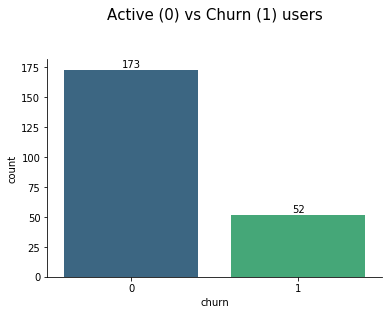

In [23]:
sns.barplot(data = churn_vs_active_users_df_pd, x = 'churn', y = 'count', palette='viridis')

sns.despine()
plt.title('Active (0) vs Churn (1) users\n\n', fontsize = 15)

counts = churn_vs_active_users_df_pd['count'].values
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

the existence of data imbalance can be observed.

In [24]:
### churn vs active user by gender
gender_df = df_churn_active_real.select(['userId','churn','gender']).dropDuplicates().groupBy('churn','gender').count().orderBy('churn').toPandas()

Text(0.5,1,'Gender active vs churn users\n\n')

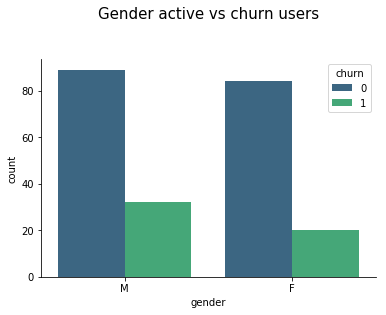

In [25]:
sns.barplot(data = gender_df, x = 'gender', y = 'count',  hue = 'churn', palette='viridis')

sns.despine()
plt.title('Gender active vs churn users\n\n', fontsize = 15)


there is no clear difference in terms of the percentage of men and women.

## Explore Data

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [26]:
pages_list = df_churn_active_real.select('page').dropDuplicates().toPandas()
pages_list = np.array(pages_list['page'])

In [27]:
def feature_engineering_page(df = df_churn_active_real, list = pages_list):
    '''
    Features are created associated with the variable 'page'
    param:
    df: spark dataframe with all data
    list: name of page 
    
    return
    features_page_df: dataframe with new features
    '''
    
    feature_page_df = df.select(['userId','churn']).distinct()

    for page in pages_list:
        if page == 'Cancellation Confirmation':
            None
        else:
            page_name = page.replace(' ','')
            print(page)
            #page_per_user = df.filter(df.page==page).groupby('userId').count()
            #page_per_user = page_per_user.withColumnRenamed('count', f'count_{page_name}')
            #feature_page_df = feature_page_df.join(page_per_user, on='userId', how='left')
            
            page_per_user_per_session = df.filter(df.page == page).groupby('userId','sessionId').count()
            page_per_user_per_session = page_per_user_per_session.groupby('userId').agg({'count':'avg'})
            page_per_user_per_session = page_per_user_per_session.withColumnRenamed('avg(count)', f'avg_count_{page_name}')
            
            feature_page_df = feature_page_df.join(page_per_user_per_session, on='userId', how='left')
    
    return feature_page_df
    

In [28]:
df_features = feature_engineering_page()

Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
About
Settings
Add to Playlist
Add Friend
NextSong
Thumbs Up
Help
Upgrade
Error
Submit Upgrade


### transform to pandas and fill nan

If you want to explore, you should uncomment these elements, and it will be possible to view the elements in a more user-friendly way.

In this case, they were left commented out because it takes time to convert the Spark DataFrame to Pandas.

In [29]:
#df_features_pd = df_features.na.fill(0).toPandas()

In [30]:
#df_features_pd

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [31]:
#we fill nan and drop user id
df_without_userId = df_features.na.fill(0).drop('userId')

### first we assemble our data

In [32]:
#All columns
inputcols = ['avg_count_Cancel', 'avg_count_SubmitDowngrade',
       'avg_count_ThumbsDown', 'avg_count_Home', 'avg_count_Downgrade',
       'avg_count_RollAdvert', 'avg_count_Logout', 'avg_count_SaveSettings',
       'avg_count_About', 'avg_count_Settings', 'avg_count_AddtoPlaylist',
       'avg_count_AddFriend', 'avg_count_NextSong', 'avg_count_ThumbsUp',
       'avg_count_Help', 'avg_count_Upgrade', 'avg_count_Error',
       'avg_count_SubmitUpgrade']

#The columns that could be considered as triggers are manually selected.

inputcols_reduced = ['avg_count_ThumbsDown', 'avg_count_Downgrade',
            'avg_count_AddtoPlaylist', 'avg_count_AddFriend', 'avg_count_NextSong',
            'avg_count_ThumbsUp', 'avg_count_Error' ]

assembler = VectorAssembler(inputCols = inputcols_reduced, outputCol = "features")

### second we scale our data

In [33]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'norm_features', withStd = True)

### Split

In [34]:
df_without_userId = df_without_userId.withColumnRenamed("churn", "label")

In [35]:
train, val = df_without_userId.randomSplit([0.7, 0.3], seed = 52)

In [36]:
evaluator=MulticlassClassificationEvaluator(metricName="f1")

## Modeling

To model the data, three models are used: logistic regression, random forest, and Linear SVC. In each case, a pipeline is created, a grid search is utilized, cross-validation is performed, and the F1 score is calculated.

## Logistic regression

In [37]:
lr_clf = LogisticRegression(featuresCol = 'norm_features', labelCol = 'label')
pipeline_lr = Pipeline(stages = [assembler, scaler, lr_clf])

In [38]:
grid_search_lr = ParamGridBuilder()\
                 .addGrid(lr_clf.regParam, [0.1])\
                 .addGrid(lr_clf.maxIter, [10])\
                 .build()

cv_lr = CrossValidator(estimator = pipeline_lr,
                       estimatorParamMaps = grid_search_lr,
                       evaluator = MulticlassClassificationEvaluator(metricName = "f1"),
                       numFolds = 3)

model_lr = cv_lr.fit(train)

model_lr.avgMetrics

best_model_lr = model_lr.bestModel
results_lr = best_model_lr.transform(val)

In [39]:
evaluator.evaluate(results_lr, {evaluator.metricName:'f1'})

0.6480431848852902

## Random Forest

In [45]:
rf_clf = RandomForestClassifier(featuresCol = 'norm_features', labelCol = 'label')
pipeline_rf = Pipeline(stages = [assembler, scaler, rf_clf])

In [46]:
grid_search_rf = ParamGridBuilder()\
                 .addGrid(rf_clf.numTrees,[5, 10])\
                 .addGrid(rf_clf.maxDepth,[2, 3])\
                 .build()

cv_rf = CrossValidator(estimator = pipeline_rf,
                       estimatorParamMaps = grid_search_rf,
                       evaluator = MulticlassClassificationEvaluator(metricName = "f1"),
                       numFolds = 3)

model_rf = cv_rf.fit(train)

model_rf.avgMetrics

best_model_rf = model_rf.bestModel
results_rf = best_model_rf.transform(val)

In [47]:
evaluator.evaluate(results_rf, {evaluator.metricName:'f1'})

0.6480431848852902

## Naive Bayes

In [48]:
nb_clf = NaiveBayes(featuresCol = 'norm_features', labelCol = 'label')
pipeline_nb = Pipeline(stages = [assembler, scaler, nb_clf])

In [49]:
grid_search_nb = ParamGridBuilder()\
                 .addGrid(nb_clf.smoothing, [0.0, 0.2])\
                 .build()

cv_nb = CrossValidator(estimator = pipeline_nb,
                       estimatorParamMaps = grid_search_nb,
                       evaluator = MulticlassClassificationEvaluator(metricName = "f1"),
                       numFolds = 3)

model_nb = cv_nb.fit(train)

model_nb.avgMetrics

best_model_nb = model_nb.bestModel
results_nb = best_model_nb.transform(val)

In [50]:
evaluator.evaluate(results_nb, {evaluator.metricName:'f1'})

0.6480431848852902

As can be observed in the previously presented results, the classifiers Random Forest, Logistic Regression, and Naive Bayes exhibit similar performance.

In practice, Random Forest should outperform the other models due to its ability to discriminate through decision trees. However, in this case, the results were similar because the grid search exploration was not extensive enough to reach the desired values.

It is suggested that in the future, further exploration and/or the utilization of different values should be considered.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.